In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [92]:
import os
from collections import OrderedDict

import torch

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 20000)

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cosine
# from MulticoreTSNE import MulticoreTSNE as TSNE

from src import config
from src.corpus.iest_corpus import IESTCorpus
from src.seq_utils.pad import Padder
from src.utils.torch import to_var

from utils.unicode_codes_py3 import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS

In [3]:
EXPERIMENT_HASH = '533aa65d2079a954ebcbda7847e046970ac97c75'
SENT_REPRS_FILENAME = 'sentence_representations.txt'
PREDICTED_LABELS_FILENAME = 'predictions.txt'

SENT_REPRS_PATH = os.path.join(config.RESULTS_PATH, EXPERIMENT_HASH, SENT_REPRS_FILENAME)

In [4]:
reprs = np.loadtxt(SENT_REPRS_PATH, encoding='utf-8')

In [5]:
reduced_reprs = PCA(n_components=3).fit_transform(reprs)

In [6]:
with open(config.TEST_EMOJI, 'r', encoding='utf-8') as f:
    tweets = f.readlines()
tweets = [tweet.rstrip() for tweet in tweets]

with open(config.TEST_LABELS, 'r', encoding='utf-8') as f:
    labels = f.readlines()
labels = [label.rstrip() for label in labels]

with open(os.path.join(config.RESULTS_PATH, EXPERIMENT_HASH, PREDICTED_LABELS_FILENAME), 'r') as f:
    pred_labels = f.readlines()
pred_labels = [l.rstrip() for l in pred_labels]

In [7]:
print(f"""
    reprs shape: {reprs.shape}
    tweets len:   {len(tweets)}
    labels len:   {len(labels)}
""")


    reprs shape: (28757, 4096)
    tweets len:   28757
    labels len:   28757



<IPython.core.display.Javascript object>


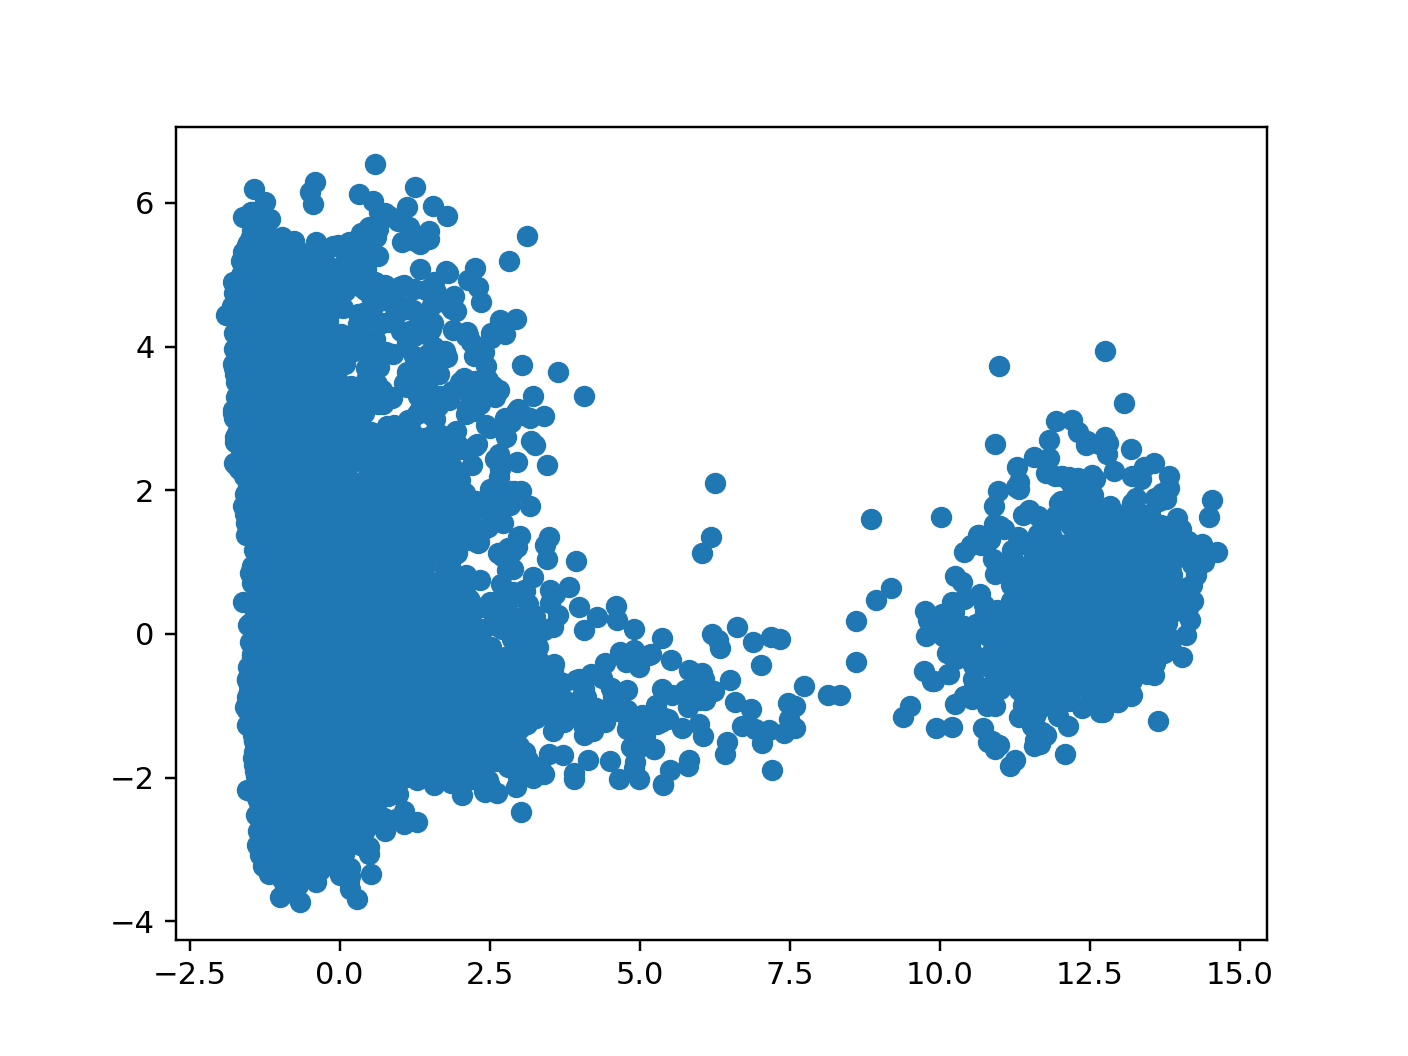

In [20]:
def plot_reduced_reprs(reduced_reprs):
    """
    parameters
    ----------
    reduced_reprs : numpy.ndarray of dim (num_examples, 2)
    """
    fig, ax = plt.subplots()
    ax.scatter(reduced_reprs[:, 0], reduced_reprs[:, 1])
plot_reduced_reprs(reduced_reprs)

# Reduced representations df

In [9]:
reduced_reprs_df = pd.DataFrame(reduced_reprs)

labels_df = pd.DataFrame(labels)
labels_df = labels_df.rename(columns={0: 'label'})

pred_labels_df = pd.DataFrame(pred_labels)
pred_labels_df = pred_labels_df.rename(columns={0: 'pred_label'})

tweets_df = pd.DataFrame(tweets)
tweets_df = tweets_df.rename(columns={0: 'tweet'})

df = pd.concat([labels_df, pred_labels_df, tweets_df, reduced_reprs_df], axis=1)

In [10]:
df.head()

,label,pred_label,tweet,0,1,2
0,sad,sad,__USERNAME__ Isn't it __TRIGGERWORD__ that this is only still a vision ?,-0.997926,4.065420,-1.178649
1,fear,fear,uhh actually couldn't sleep well last night because i was actually __TRIGGERWORD__ that id wake up to no insurance,-0.827455,-2.222673,1.805142
2,surprise,anger,"People where just __TRIGGERWORD__ because we are finding out on Thursday . If you play it back , he clearly said "" You "" . #EastEnders #EELive",-0.583758,-0.646814,1.023038
3,fear,surprise,__USERNAME__ Hello ! __USERNAME__ hit their target yesterday and we're __TRIGGERWORD__ that the campaign is no longer visible to new users .,0.151995,0.741538,1.637047
4,fear,fear,She doesnt have tonbe __TRIGGERWORD__ because she's the first lady 👑 💄 💎 💍,-0.497560,-0.836984,-0.717881


## Separate by label

In [11]:
labels = df['label'].unique().tolist()
label_sep_data = {}
for label in labels:
    label_sep_data[label] = df[df['label'] == label]

In [12]:
pred_label_sep_data = {}
for label in labels:
    pred_label_sep_data[label] = df[df['pred_label'] == label]

In [13]:
def scatter_3d(label_sep_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for label in labels:
        x = label_sep_data[label][0].values
        y = label_sep_data[label][1].values
        z = label_sep_data[label][2].values
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.scatter(x[:500], y[:500], z[:500], label=label, cmap=plt.cm.tab10)
        ax.legend()
        
def scatter_2d(label_sep_data):
    fig, ax = plt.subplots()

    for label in labels:
        x = tsne_label_sep_data[label][0].values
        y = tsne_label_sep_data[label][1].values
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.scatter(x[:500], y[:500], label=label, cmap=plt.cm.tab10)
        ax.legend()

<IPython.core.display.Javascript object>


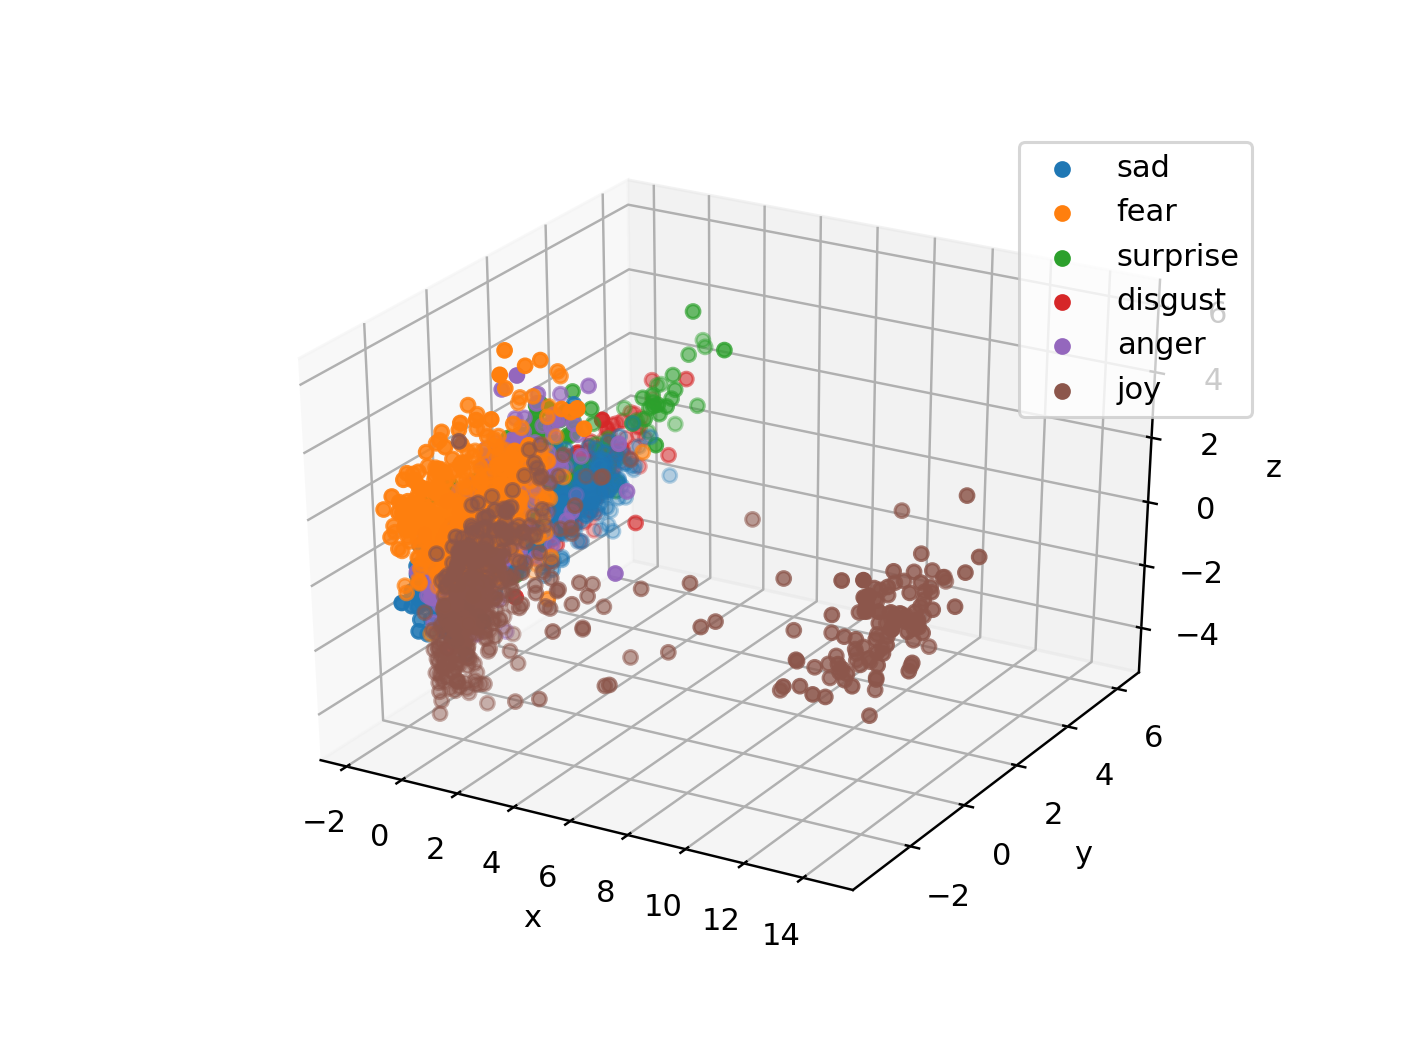

In [21]:
scatter_3d(label_sep_data)

We can see that the joy labels are separated into two notorious clusters. The same happens when we color with the predicted labels: 

<IPython.core.display.Javascript object>


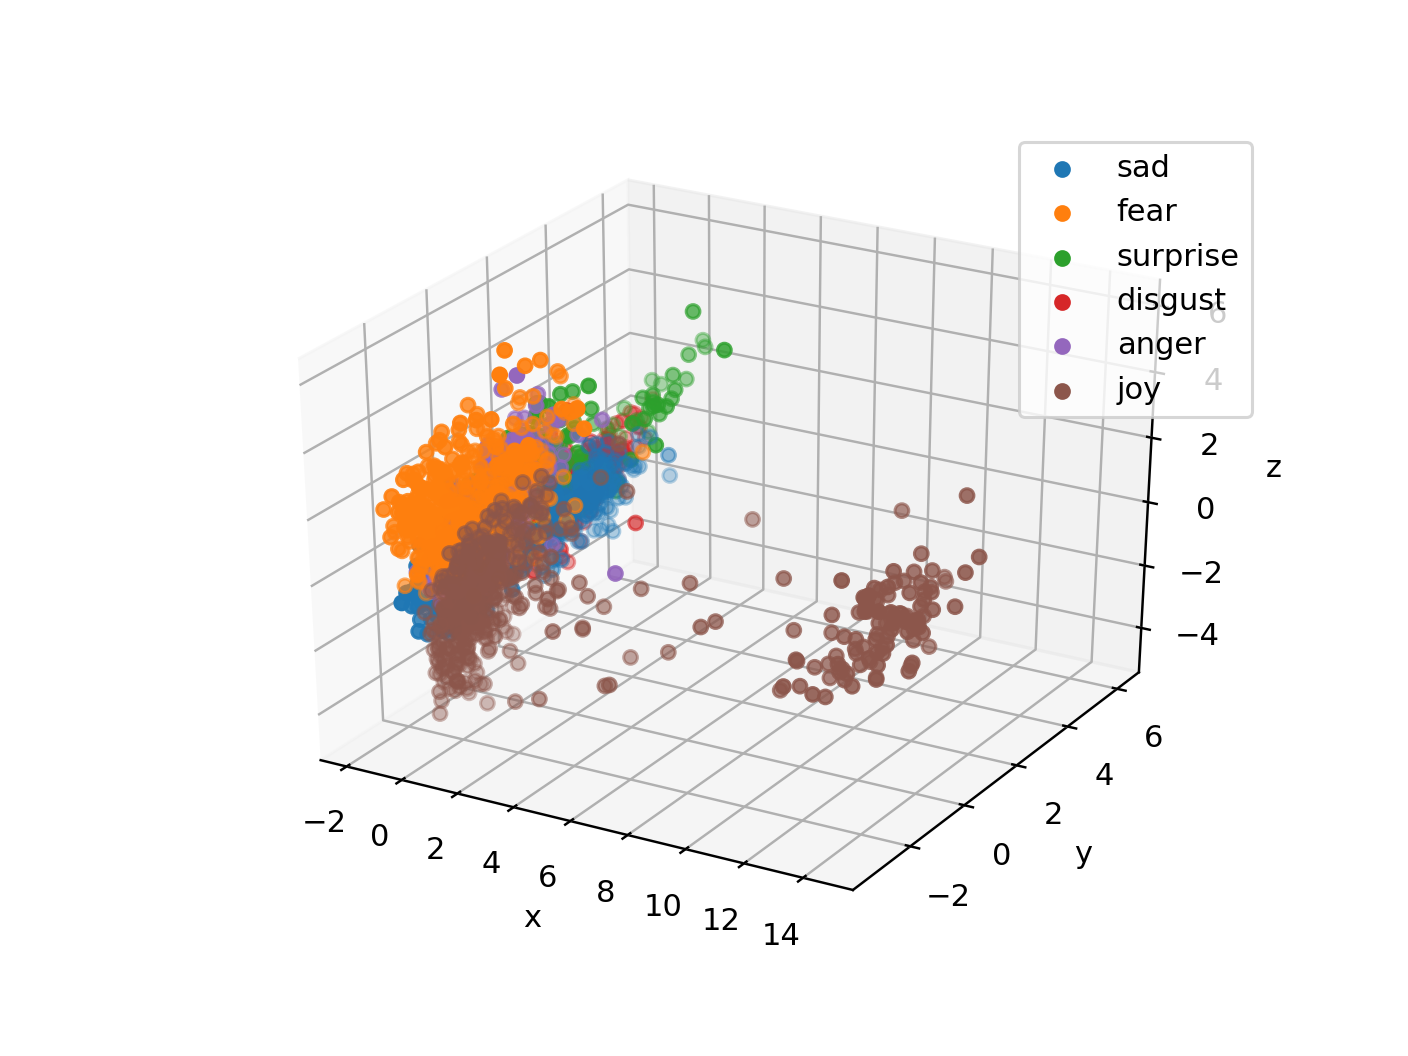

In [22]:
scatter_3d(pred_label_sep_data)

In [16]:
joy_df = label_sep_data['joy']
#joy_df[joy_df[0] > 10]['tweet'].to_csv('weird_joys.txt')

If we inspect those examples that are separated we see that they correspond to those that have the pattern `un __TRIGGERWORD__`

In [17]:
joy_df[joy_df[0] > 10]['tweet']

79       45 ) I am un __TRIGGERWORD__ when not in a romantic relationship .                                                                                                                         
82       __USERNAME__ Do I need a reason ? * lets himself in * Don't look so un __TRIGGERWORD__ that I'm here                                                                                       
100      __USERNAME__ I am un __TRIGGERWORD__ that there is no Claxstone Smooth Blue at the deli ! __USERNAME__                                                                                     
103      Fun fact : Most Cats are very un __TRIGGERWORD__ that humans now know this about them . __URL__                                                                                            
145      All of my best memories revolve around one or all of those , in some way . I'm never un __TRIGGERWORD__ when creating . It fills me with pure bliss .                                      
260      im un 

Those that are closer to the main cluster don't have the 'un'

In [18]:
joy_df[joy_df[0] < 2]['tweet']

15       __USERNAME__ __USERNAME__ __USERNAME__ __USERNAME__ If they were really going to have a #TrumpImpeachment it would've happened already & know that I'm not __TRIGGERWORD__ that he's in office either .
30       I feel very " __TRIGGERWORD__ because i will playing my favorite game =))                                                                                                                              
38       i am somehow __TRIGGERWORD__ that we're informed late last fri about the suspension 😂 __NEWLINE__ no exam for tomorrow = halfday 🤗                                                                     
47       I #truly felt so # __TRIGGERWORD__ when I read this . . . __NEWLINE__ #review #testimonial #clienttestimonial #goals … __URL__                                                                         
52       __USERNAME__ I get so __TRIGGERWORD__ when have new fanfictions Huddy and Hachel . 😍                                                                       

## What happens when we apply t-SNE?

In [19]:
tsne_reprs = TSNE(
    n_jobs=20,
#     n_iter=args.num_epochs,
#     perplexity=args.perplexity,
#     learning_rate=args.learning_rate
).fit_transform(reprs)

NameError: name 'TSNE' is not defined

In [ ]:
df_tsne = pd.concat([labels_df, pred_labels_df, tweets_df, pd.DataFrame(tsne_reprs)], axis=1)

In [ ]:
labels = df['label'].unique().tolist()
tsne_label_sep_data = {}
for label in labels:
    tsne_label_sep_data[label] = df_tsne[df_tsne['label'] == label]

In [ ]:
scatter_2d(tsne_label_sep_data)

We don't get very interesting results. Again we see that there is more than one cluster for the `joy` labels. It probably is the same as the one we found with PCA.

## `un __TRIGGERWORD__`

In [23]:
un_tweets = joy_df[joy_df[0] > 10]
un_tweets.head()

,label,pred_label,tweet,0,1,2
79,joy,joy,45 ) I am un __TRIGGERWORD__ when not in a romantic relationship .,13.592623,0.427561,-0.590937
82,joy,joy,__USERNAME__ Do I need a reason ? * lets himself in * Don't look so un __TRIGGERWORD__ that I'm here,10.761692,0.298092,-1.251867
100,joy,joy,__USERNAME__ I am un __TRIGGERWORD__ that there is no Claxstone Smooth Blue at the deli ! __USERNAME__,11.821869,0.725126,-0.260774
103,joy,joy,Fun fact : Most Cats are very un __TRIGGERWORD__ that humans now know this about them . __URL__,12.594954,0.372369,-1.033216
145,joy,joy,"All of my best memories revolve around one or all of those , in some way . I'm never un __TRIGGERWORD__ when creating . It fills me with pure bliss .",13.710793,0.448416,-0.755244


In [24]:
print(f"""
    {un_tweets['label'].value_counts()}
    
    {un_tweets['pred_label'].value_counts()}
""")


    joy    1117
Name: label, dtype: int64
    
    joy    1117
Name: pred_label, dtype: int64



All the tweets in the weird cluster were correctly predicted

## Misclassified analysis
Let's see what happens with the tweets that were incorrectly classified:

<IPython.core.display.Javascript object>


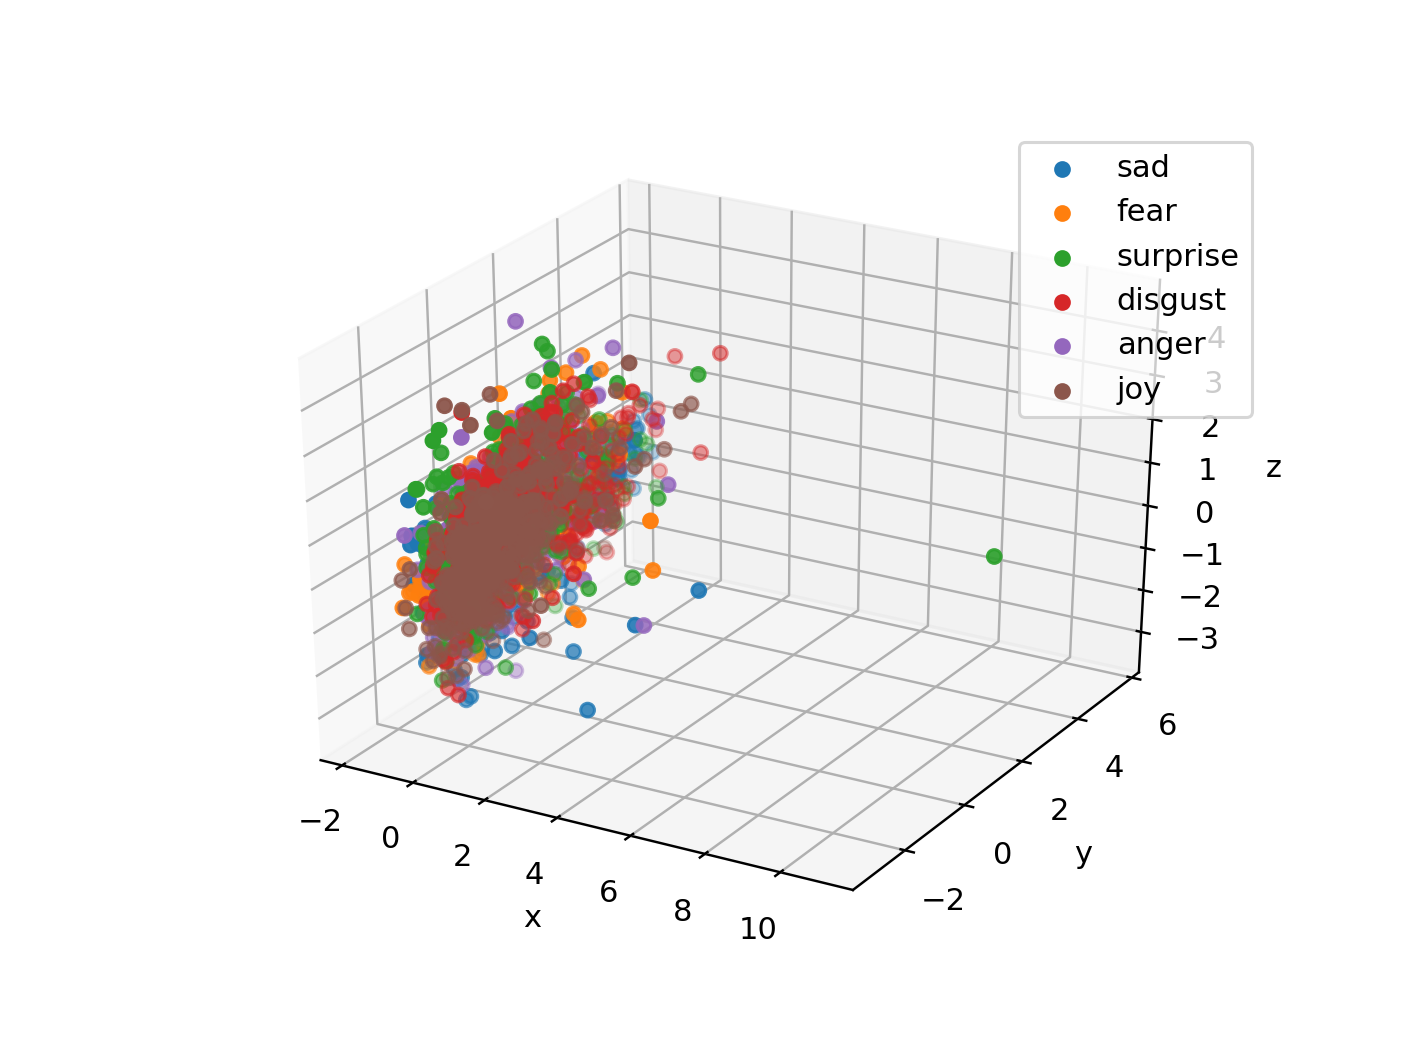

In [25]:
misclassified_tweets = df[df['label'] != df['pred_label']]
labels = df['label'].unique().tolist()
sep_misclassified = {}
for label in labels:
    sep_misclassified[label] = misclassified_tweets[misclassified_tweets['label'] == label]
scatter_3d(sep_misclassified)

It seems that they're all mixed up, which is what we would expect. What about those correctly classified?

<IPython.core.display.Javascript object>


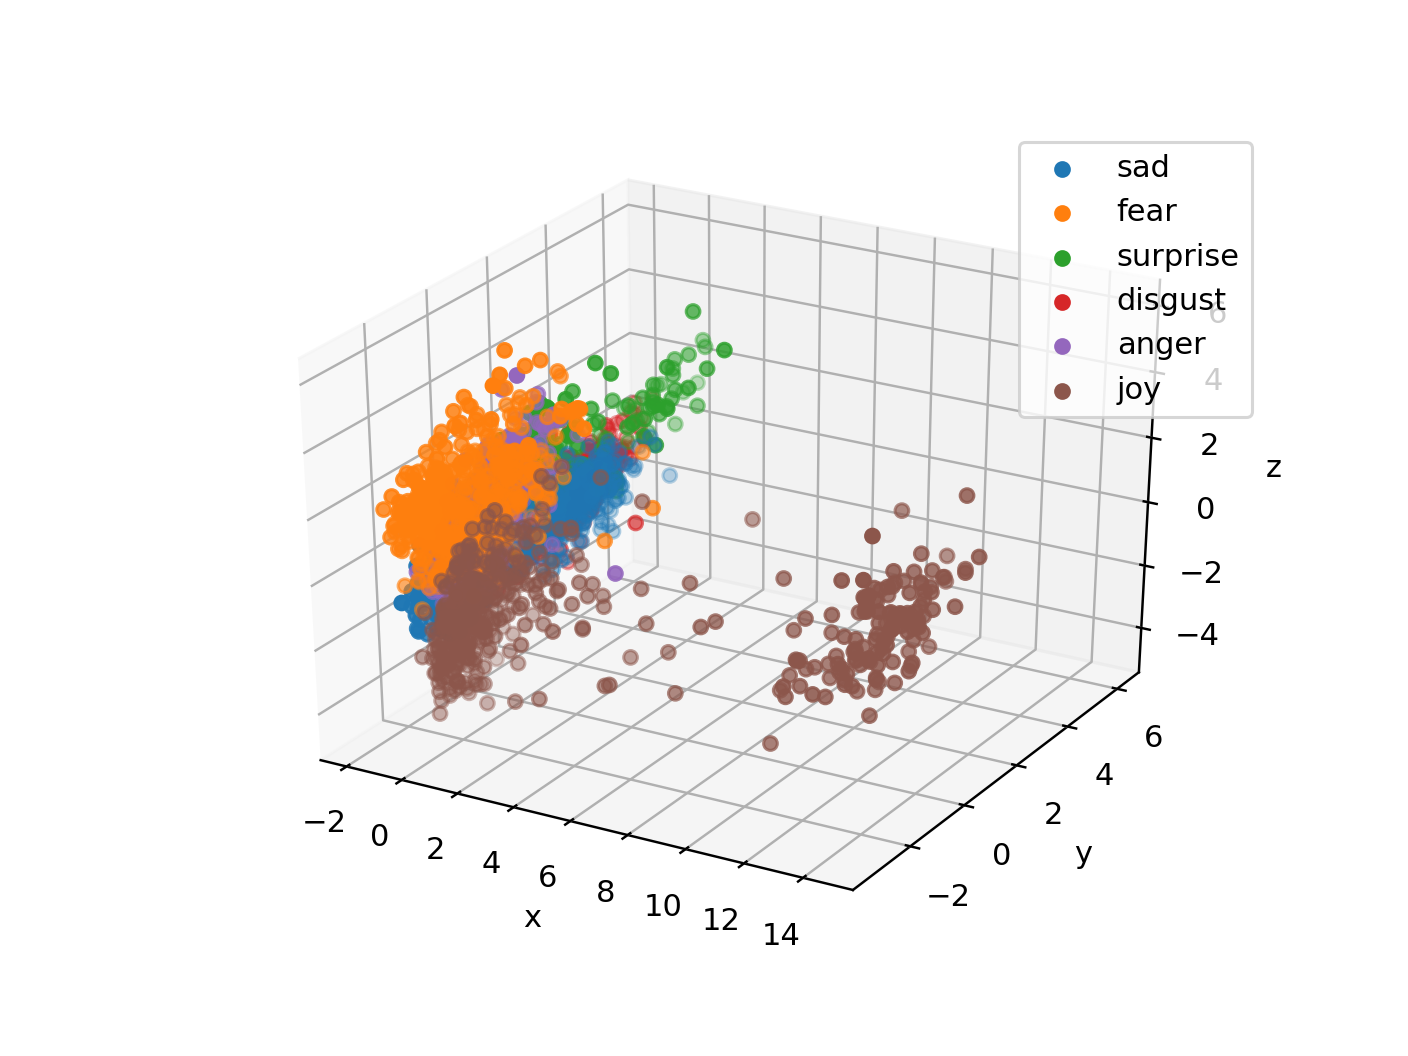

In [26]:
misclassified_tweets = df[df['label'] == df['pred_label']]
labels = df['label'].unique().tolist()
sep_misclassified = {}
for label in labels:
    sep_misclassified[label] = misclassified_tweets[misclassified_tweets['label'] == label]
scatter_3d(sep_misclassified)

It seems like clusters are more separate, but it's hard to tell.

# Custom sentences
Let's now encode some custom sentences and see which one are the closest ones.

In [27]:
model = torch.load('data/results/533aa65d2079a954ebcbda7847e046970ac97c75/best_model.pth')
iest_emoji_corpus = IESTCorpus(config.corpora_dict, corpus_name='iest_emoji')
lang = iest_emoji_corpus.lang

/home/jabalazs/miniconda3/envs/py3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'src.models.iest.IESTClassifier' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Loading .cache/iest_emoji_lang.pkl
Loading .cache/iest_emoji_train.pkl
Loading .cache/iest_emoji_train_chars.pkl
Loading .cache/iest_emoji_dev.pkl
Loading .cache/iest_emoji_dev_chars.pkl
Loading .cache/iest_emoji_test.pkl
Loading .cache/iest_emoji_test_chars.pkl


In [137]:
class Tester(object):
    def __init__(self, model, lang, batch_size=64):
        """
        Provide functions for analyzing a pytorch model
        
        Parameters
        ----------
        model : Class inheriting from torch.nn.Module
            This model must provide and `encode` method with the 
            following signature:
                args:
                    padded_word_ids : numpy.ndarray of shape (N, max_sent_len)
                    padded_char_ids : numpy.ndarray of shape (N, max_sent_len, max_word_len)
                    sent_lengths : torch.FloatTensor of shape (N)
                    word_lengths : torch.FloatTensor of shape (N, max_sent_len)
                kwargs:
                    masks : torch.FloatTensor of shape (N, max_sent_len)
        lang : Lang
            class providing functionality for transforming words and chars to ids.
            It should provide at least the methods:
                sents2ids : list of tokens -> list of ids
                sents2char_ids : list of tokens -> list of lists of char ids
        batch_size : int
        """
        self.model = model
        self.lang = lang
        
        self.batch_size = 64
        
        self.padder = Padder(config.PAD_ID)
        
    def sent_batch2input(self, batch, input_is_words=False, tokenize=True):
        if tokenize:
            batch = [ex.split() for ex in batch]
            
        if input_is_words:
            word_ids = []
            for word in batch:
                try:
                    word_ids.append([self.lang.token2id[word]])
                except KeyError:
                    word_ids.append([config.UNK_ID])
    
        else:
            word_ids = self.lang.sents2ids(batch)
        
        char_ids = self.lang.sents2char_ids(batch)

        (padded_word_ids,
         _,
         sent_masks) = self.padder.pad1d(word_ids)

        (padded_char_ids,
         _,
         word_lengths,
         word_masks) = self.padder.pad2d(char_ids)
        
    
        sent_lengths = np.array([len(example) for example in batch])
        sent_lengths = to_var(torch.FloatTensor(sent_lengths), use_cuda=True,
                              requires_grad=False)
        sent_masks = to_var(torch.FloatTensor(sent_masks), use_cuda=True,
                            requires_grad=False)
        word_lengths = to_var(torch.FloatTensor(word_lengths), use_cuda=True,
                              requires_grad=False)
        
        
        return [[]], {'masks': sent_masks, 'raw_sequences': batch, 'sent_lengths': sent_lengths,
                      'char_batch': None, 'word_lengths': word_lengths}
    
    def sent_batch2vec(self, batch, input_is_words=False, tokenize=True):
        args, kwargs = self.sent_batch2input(batch, input_is_words=input_is_words, tokenize=tokenize)
        
        # This way this function doesn't need to know anything about the input to the encode function.
        # We just need to define the function that transforms the batch into proper inputs for the specific model
        # we're using
        encoded = self.model.encode(*args, **kwargs)
        logits = self.model.dense_layer(encoded)
        
        encoded = encoded.data.cpu().numpy()
        logits = logits.data.cpu().numpy()
        return encoded, logits
    
    def sents2vec(self, sents, input_is_words=False, tokenize=True):
        sent_vecs = []
        logits_list = []

        # some sentences from samples are empty
        sents = [elem if elem != '' else '-' for elem in sents]
        for batch_idx in range(0, len(sents), self.batch_size):


            curr_slice = sents[batch_idx:batch_idx + self.batch_size]

            encoded, logits = self.sent_batch2vec(curr_slice, input_is_words=input_is_words, tokenize=tokenize)
            
            sent_vecs.append(encoded)
            logits_list.append(logits)
            
        sent_vecs = np.vstack(sent_vecs)
        logits = np.vstack(logits_list)
                
        return {
            'sent_repr': sent_vecs,
            'logits': logits,
        }

tester = Tester(model, lang)

I want to encode these emoji as sentences and see which ones are the closest

In [138]:
emoji_sents = OrderedDict({
    'joy': '😂',
    'sob': '😭',
    'cry': '😢',
    'blush': '😊',
})

## Emoji Nearest Neighbors

In [139]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine')
neighbors.fit(reprs)

def get_correct_nns(emoji_sents, neighbors, n_neighbors=100):

    encoded_sents = tester.sents2vec(emoji_sents.values(), tokenize=True)

    emoji_nn = {}
    for idx, (emoji_name, emoji) in enumerate(emoji_sents.items()):
        nn_ids = neighbors.kneighbors(encoded_sents['sent_repr'][idx].reshape(1, -1), n_neighbors=n_neighbors,
                                      return_distance=False) 
        emoji_nn[emoji_name] = df.loc[nn_ids[0]]

    for emoji_name, emoji in emoji_sents.items():
        # Get correctly predicted tweets from NNs
        tmp_df = emoji_nn[emoji_name]
        correct = tmp_df[tmp_df['label'] == tmp_df['pred_label']]
        
        print(f"""{emoji}: {len(correct)} ({len(correct)/n_neighbors:.1%})""")

In [140]:
get_correct_nns(emoji_sents, neighbors, n_neighbors=100)

/home/jabalazs/repos/implicit_emotion/src/utils/torch.py:54: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  sent_output, _ = module(sent_packed)


😂: 55 (55.0%)
😭: 51 (51.0%)
😢: 47 (47.0%)
😊: 91 (91.0%)


I want to use the `get_correct_nns` function to see how the proportion of correctly predicted tweets varies with the amount of neighbors we study. For example when analyzing 100 nearest neighbors we can see that roughly half of the tweets corresponding to 😂, 😭, 😢 are correctly classified, leading us to believe that these emoji are not significant features at this level. However out of 100 nearest neighbors of 😊, 91 were correctly predicted, showing that 😊 is a good indicator of joy.

As we increase the number of nearest neighbors the proportion tends towards the global accuracy (~69.3%) for every emoji. 

In [32]:
get_correct_nns(emoji_sents, neighbors, n_neighbors=500)

/home/jabalazs/repos/implicit_emotion/src/utils/torch.py:54: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  sent_output, _ = module(sent_packed)


😂: 307 (61.4%)
😭: 332 (66.4%)
😢: 335 (67.0%)
😊: 401 (80.2%)


When observing 500 nns we can see that the proportion increases for the first three emoji, and decreases a bit for the last, however this one keeps being a more prominent feature than the others. 

I want to know all the emojis present in the training dataset

In [33]:
def get_emoji_in_iterable(iterable):
    return set(iterable).intersection(set(UNICODE_EMOJI.keys()))
train_emoji = get_emoji_in_iterable(lang.token_freqs.keys())

def get_emoji_freqs(lang, emojis):
    freqs = []
    for emoji in emojis:
        freqs.append((emoji, lang.token_freqs[emoji]))
    return sorted(freqs, key=lambda x: x[1], reverse=True)
    
emoji_freqs = get_emoji_freqs(lang, train_emoji)
emoji_freqs


[('😂', 8404),
 ('😭', 3865),
 ('❤', 1970),
 ('😩', 1355),
 ('😷', 1324),
 ('😊', 1238),
 ('😍', 1024),
 ('😔', 916),
 ('😒', 866),
 ('😡', 794),
 ('😢', 744),
 ('😅', 630),
 ('💕', 561),
 ('😁', 503),
 ('☺', 499),
 ('💔', 489),
 ('😕', 436),
 ('😳', 432),
 ('😞', 431),
 ('😘', 425),
 ('🙌', 390),
 ('😤', 367),
 ('🙄', 334),
 ('💀', 332),
 ('💖', 324),
 ('😏', 313),
 ('😑', 304),
 ('💜', 294),
 ('👌', 282),
 ('😐', 280),
 ('💙', 276),
 ('😓', 275),
 ('🙏', 274),
 ('🙈', 271),
 ('☹', 268),
 ('👏', 265),
 ('😪', 265),
 ('😖', 262),
 ('✨', 254),
 ('👍', 239),
 ('🙃', 237),
 ('😫', 236),
 ('💯', 227),
 ('😄', 221),
 ('♀', 218),
 ('😱', 218),
 ('😠', 216),
 ('😌', 207),
 ('💗', 207),
 ('😣', 197),
 ('🤔', 195),
 ('🔥', 194),
 ('🎶', 193),
 ('🎉', 187),
 ('💞', 175),
 ('😉', 173),
 ('♥', 169),
 ('😆', 164),
 ('👀', 160),
 ('😴', 158),
 ('😃', 153),
 ('💘', 152),
 ('😥', 150),
 ('🤷', 148),
 ('💛', 143),
 ('✌', 141),
 ('😀', 140),
 ('😎', 138),
 ('😰', 137),
 ('🤗', 136),
 ('💁', 135),
 ('🤦', 129),
 ('🤣', 126),
 ('😬', 120),
 ('👊', 117),
 ('👎', 116),
 ('🙊'

In [34]:
# The [1:-1] is for omitting the colons that come included in the emoji alias `:joy:` -> `joy`
emoji_sents = {UNICODE_EMOJI_ALIAS[emoji_freq[0]][1:-1]: emoji_freq[0] for emoji_freq in emoji_freqs[:20]}
get_correct_nns(emoji_sents, neighbors, n_neighbors=500)

/home/jabalazs/repos/implicit_emotion/src/utils/torch.py:54: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  sent_output, _ = module(sent_packed)


😂: 307 (61.4%)
😭: 333 (66.6%)
❤: 400 (80.0%)
😩: 332 (66.4%)
😷: 396 (79.2%)
😊: 403 (80.6%)
😍: 404 (80.8%)
😔: 336 (67.2%)
😒: 321 (64.2%)
😡: 330 (66.0%)
😢: 332 (66.4%)
😅: 320 (64.0%)
💕: 389 (77.8%)
😁: 369 (73.8%)
☺: 383 (76.6%)
💔: 337 (67.4%)
😕: 326 (65.2%)
😳: 330 (66.0%)
😞: 328 (65.6%)
😘: 375 (75.0%)


## Tweets containing some specific emoji

In [39]:
emoji_tweets_df = df[df['tweet'].str.contains('|'.join(train_emoji))]
no_emoji_tweets_df = df[~df['tweet'].str.contains('|'.join(train_emoji))]

In [40]:
emoji_tweets_df.head()

,label,pred_label,tweet,0,1,2
4,fear,fear,She doesnt have tonbe __TRIGGERWORD__ because she's the first lady 👑 💄 💎 💍,-0.497560,-0.836984,-0.717881
11,fear,sad,I was looking so hard at my comp screen __TRIGGERWORD__ that it's just dirty but it's not so baekhyun has a mole on his right cheek 😝,-0.596140,-0.255719,-0.260914
12,fear,joy,Dude don't make me choose . And I'm __TRIGGERWORD__ that ww3 might start because of this . 💗 Exo-ls 💗 & 💗 armys 💗 are nOt on good terms __URL__,-0.363409,-1.898268,0.277449
13,disgust,disgust,Blehh i think its so __TRIGGERWORD__ when dogs lick people's mouths 😷,-1.498788,4.083839,-1.523863
16,surprise,surprise,"__USERNAME__ They really do 😒 . People are always __TRIGGERWORD__ when I tell them I'm from RI , since I'm friendlier than the stereotypical NEer",-0.450547,0.620384,1.782867


In [41]:
no_emoji_tweets_df.head()

,label,pred_label,tweet,0,1,2
0,sad,sad,__USERNAME__ Isn't it __TRIGGERWORD__ that this is only still a vision ?,-0.997926,4.065420,-1.178649
1,fear,fear,uhh actually couldn't sleep well last night because i was actually __TRIGGERWORD__ that id wake up to no insurance,-0.827455,-2.222673,1.805142
2,surprise,anger,"People where just __TRIGGERWORD__ because we are finding out on Thursday . If you play it back , he clearly said "" You "" . #EastEnders #EELive",-0.583758,-0.646814,1.023038
3,fear,surprise,__USERNAME__ Hello ! __USERNAME__ hit their target yesterday and we're __TRIGGERWORD__ that the campaign is no longer visible to new users .,0.151995,0.741538,1.637047
5,fear,fear,"I think they're running __TRIGGERWORD__ because they know me . When I'm done , I'm done . You may as well be dead to me .",-0.450020,-1.300497,0.622689


In [135]:
total_emoji_tweets = len(emoji_tweets_df)
correct_emoji_tweets = len(emoji_tweets_df[emoji_tweets_df['label'] == emoji_tweets_df['pred_label']])
print(f'Tweets with emoji: {total_emoji_tweets}')
print(f'Tweets with emoji correctly classified: {correct_emoji_tweets / total_emoji_tweets:.1%}')

Tweets with emoji: 4805
Tweets with emoji correctly classified: 76.6%


In [136]:
total_no_emoji_tweets = len(no_emoji_tweets_df)
correct_no_emoji_tweets = len(no_emoji_tweets_df[no_emoji_tweets_df['label'] == no_emoji_tweets_df['pred_label']])
print(f'Tweets without emoji: {total_no_emoji_tweets}')
print(f'Tweets without emoji correctly classified: {correct_no_emoji_tweets / total_no_emoji_tweets:.1%}')

Tweets without emoji: 23952
Tweets without emoji correctly classified: 68.0%


Emoji are good indicators of the TRIGGERWORD's sentiment

In [174]:
def get_correct_proportions(df, emoji_list, comparand_key='pred_label'):

    ret_list = []
    for emoji in emoji_list:
        tmp_df = df[df['tweet'].str.contains(emoji)]
        correct = tmp_df[tmp_df['label'] == tmp_df[comparand_key]]
        ret_list.append(OrderedDict({
            'emoji': emoji,
            'emoji_alias': UNICODE_EMOJI_ALIAS[emoji][1:-1],
            'total_amt': len(tmp_df),
            'correct_amt': len(correct),
            'correct_proportion': round(len(correct) / (len(tmp_df) + 1e-12), 4)
        }))
    return pd.DataFrame(ret_list)


In [79]:
correct_proportions = get_correct_proportions(emoji_tweets_df, [emoji_freq[0] for emoji_freq in emoji_freqs])
correct_proportions = correct_proportions.sort_values(['correct_proportion', 'total_amt'], ascending=False)

In [112]:
correct_proportions[correct_proportions['total_amt'] > 10]

,emoji,emoji_alias,total_amt,correct_amt,correct_proportion
46,😠,angry,22,21,0.9545
4,😷,mask,163,154,0.9448
12,💕,two_hearts,87,81,0.9310
37,😖,confounded,39,36,0.9231
52,🎶,notes,38,35,0.9211
86,☀,sunny,12,11,0.9167
92,😈,smiling_imp,12,11,0.9167
54,💞,revolving_hearts,23,21,0.9130
57,😆,satisfied,23,21,0.9130
88,💦,sweat_drops,11,10,0.9091


Tweets containing some specific emoji are predicted correctly more often than others. It would be interesting to feed the model these tweets with the emoji removed and see how the proportion changes; then we would get the true contribution of the emoji to the classification performance.

### True effect of emoji on tweets

In [163]:
mask_tweets_df = emoji_tweets_df[emoji_tweets_df['tweet'].str.contains('😷')]
mask_tweets = mask_tweets_df['tweet'].values.tolist()
mask_tweets_emoji_removed = [tweet.replace('😷', '').strip() for tweet in mask_tweets]
mask_tweets_emoji_removed

["Blehh i think its so __TRIGGERWORD__ when dogs lick people's mouths",
 '__USERNAME__ I was so __TRIGGERWORD__ when they got together  I loved emmet but ted was so pathetic to me for some reason',
 '“ __USERNAME__ : I get so __TRIGGERWORD__ when people chew with their mouths open 😝  ”',
 'Wow this is a let down , thought he was going to sack himself or Metiria not be __TRIGGERWORD__ because two people are leaving for moral reasons .',
 '__USERNAME__ no man the puppy smells __TRIGGERWORD__ because of the shelter',
 'I just found my old x-rays while cleaning my room and I instantly was __TRIGGERWORD__ because they look gross af . 😖',
 'How can Kim wear so much make up all day every day .... I feel __TRIGGERWORD__ when I accidentally put on too much foundation ....',
 "It's __TRIGGERWORD__ when a guy has long nails",
 '__TRIGGERWORD__ that planned parenthood sells the body parts & organs of the babies they abort',
 'When your apartment is so ratchet and __TRIGGERWORD__ because no one fee

In [164]:
def predict(sents, tokenize=True):
    out = tester.sents2vec(sents, tokenize=tokenize)
    pred_ids = out['logits'].argmax(axis=1)
    pred_labels = [config.ID2LABEL[id_] for id_ in pred_ids]
    return pred_labels


In [171]:
no_emoji_predictions = predict(mask_tweets_emoji_removed, tokenize=True)

/home/jabalazs/repos/implicit_emotion/src/utils/torch.py:54: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
  sent_output, _ = module(sent_packed)


In [173]:
mask_tweets_df.loc[:, 'no_emoji_label'] = no_emoji_predictions
mask_tweets_df

/home/jabalazs/miniconda3/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,label,pred_label,tweet,0,1,2,no_emoji_label
13,disgust,disgust,Blehh i think its so __TRIGGERWORD__ when dogs lick people's mouths 😷,-1.498788,4.083839,-1.523863,disgust
152,disgust,joy,__USERNAME__ I was so __TRIGGERWORD__ when they got together 😷 I loved emmet but ted was so pathetic to me for some reason,-1.107227,-1.192296,-2.372456,joy
349,disgust,disgust,“ __USERNAME__ : I get so __TRIGGERWORD__ when people chew with their mouths open 😝 😷 ”,-1.236472,-0.078276,-1.072457,disgust
350,anger,joy,"Wow this is a let down , thought he was going to sack himself or Metiria not be __TRIGGERWORD__ because two people are leaving for moral reasons . 😷",3.068739,0.611655,2.881025,joy
402,disgust,disgust,__USERNAME__ no man the puppy smells __TRIGGERWORD__ because of the shelter 😷,-0.473164,0.673427,-0.030939,disgust
748,disgust,disgust,I just found my old x-rays while cleaning my room and I instantly was __TRIGGERWORD__ because they look gross af . 😖 😷,-0.721802,-0.013326,-0.365340,disgust
937,disgust,disgust,How can Kim wear so much make up all day every day .... I feel __TRIGGERWORD__ when I accidentally put on too much foundation .... 😷 😷 😷,-0.601626,1.366189,-1.168290,disgust
1128,disgust,disgust,It's __TRIGGERWORD__ when a guy has long nails 😷,-1.633955,4.038638,-1.382169,disgust
1154,disgust,disgust,__TRIGGERWORD__ that planned parenthood sells the body parts & organs of the babies they abort 😷,-1.394096,1.782816,-0.455661,disgust
1188,disgust,disgust,When your apartment is so ratchet and __TRIGGERWORD__ because no one feels like they have to clean .. 😊 😍 😷,-0.374854,1.513051,-0.727285,disgust


In [176]:
get_correct_proportions(mask_tweets_df, ['😷'], comparand_key='no_emoji_label')

,emoji,emoji_alias,total_amt,correct_amt,correct_proportion
0,😷,mask,163,134,0.8221


## Hashtags

In [114]:
hashtag_tweets_df = df[df['tweet'].str.contains('#\w+\s')]
no_hashtag_tweets_df = df[~df['tweet'].str.contains('#\w+\s')]

In [115]:
hashtag_tweets_df.head()

,label,pred_label,tweet,0,1,2
2,surprise,anger,"People where just __TRIGGERWORD__ because we are finding out on Thursday . If you play it back , he clearly said "" You "" . #EastEnders #EELive",-0.583758,-0.646814,1.023038
15,joy,joy,__USERNAME__ __USERNAME__ __USERNAME__ __USERNAME__ If they were really going to have a #TrumpImpeachment it would've happened already & know that I'm not __TRIGGERWORD__ that he's in office either .,0.675041,0.516015,1.298187
46,surprise,surprise,"#news Lion opens car door , terrifies family : A family in South Africa was __TRIGGERWORD__ when a … __URL__",-0.302169,0.099888,2.723735
47,joy,joy,I #truly felt so # __TRIGGERWORD__ when I read this . . . __NEWLINE__ #review #testimonial #clienttestimonial #goals … __URL__,-0.557278,-0.088777,-2.265183
49,surprise,surprise,Yokesh __USERNAME__ : What ? Azhar Mahmood playing ? I was __TRIGGERWORD__ when he was picked in #KKR squad . Now he is batti ... __URL__,-0.350071,-0.620149,0.852084


In [116]:
no_hashtag_tweets_df.head()

,label,pred_label,tweet,0,1,2
0,sad,sad,__USERNAME__ Isn't it __TRIGGERWORD__ that this is only still a vision ?,-0.997926,4.065420,-1.178649
1,fear,fear,uhh actually couldn't sleep well last night because i was actually __TRIGGERWORD__ that id wake up to no insurance,-0.827455,-2.222673,1.805142
3,fear,surprise,__USERNAME__ Hello ! __USERNAME__ hit their target yesterday and we're __TRIGGERWORD__ that the campaign is no longer visible to new users .,0.151995,0.741538,1.637047
4,fear,fear,She doesnt have tonbe __TRIGGERWORD__ because she's the first lady 👑 💄 💎 💍,-0.497560,-0.836984,-0.717881
5,fear,fear,"I think they're running __TRIGGERWORD__ because they know me . When I'm done , I'm done . You may as well be dead to me .",-0.450020,-1.300497,0.622689


In [130]:
total_hashtag_tweets = len(hashtag_tweets_df)
correct_hashtag_tweets = len(hashtag_tweets_df[hashtag_tweets_df['label'] == hashtag_tweets_df['pred_label']])
print(f'Tweets with hashtags: {total_hashtag_tweets}')
print(f'Tweets with hashtags correctly classified: {correct_hashtag_tweets / total_hashtag_tweets:.1%}')

Tweets with hashtags: 2122
Tweets with hashtags correctly classified: 70.5%


In [129]:
total_no_hashtag_tweets = len(no_hashtag_tweets_df)
correct_no_hashtag_tweets = len(no_hashtag_tweets_df[no_hashtag_tweets_df['label'] == no_hashtag_tweets_df['pred_label']])
print(f'Tweets with no hashtags: {total_no_hashtag_tweets}')
print(f'Tweets with no hashtags correctly classified: {correct_no_hashtag_tweets / total_no_hashtag_tweets:.1%}')

Tweets with no hashtags: 26635
Tweets with no hashtags correctly classified: 69.4%


Hashtags also seem to help, but not as much as emoji

In [133]:
emoji_hashtag_tweets_df = hashtag_tweets_df[hashtag_tweets_df['tweet'].str.contains('|'.join(train_emoji))]
emoji_no_hashtag_tweets_df = emoji_tweets_df[~emoji_tweets_df['tweet'].str.contains('#\w+\s')]
print(f'Tweets with emoji and hashtags: {len(emoji_hashtag_tweets_df)}')
print(f'Tweets with emoji and no hashtag: {len(emoji_no_hashtag_tweets_df)}')

Tweets with emoji and hashtags: 345
Tweets with emoji and no hashtag: 4460
